## Text-to-image dreambooth finetuning using transformers specific pipeline component

DreamBooth is a method for personalizing text-to-image models. It fine-tunes these models using 5-10 images of a specific subject, allowing them to generate personalized images based on textual prompts

This sample shows how to use `transformers_text_to_image_dreambooth_finetuning_pipeline` component from the `azureml` system registry to fine tune a model for text to image task using dog Dataset. We then deploy the fine tuned model to an online endpoint for real time inference.

### Training data
We will use the [dog-example](https://huggingface.co/datasets/diffusers/dog-example) dataset.

### Model
We will use the `runwayml-stable-diffusion-v1-5` model in this notebook. If you need to fine tune a model that is available on HuggingFace, but not available in `azureml` system registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from HuggingFace.

### Outline
1. Install dependencies
2. Setup pre-requisites such as compute
3. Pick a model to fine tune
4. Prepare dataset for finetuning the model
5. Submit the fine tuning job using transformers specific image-classification component
6. Review training and evaluation metrics
7. Register the fine tuned model
8. Deploy the fine tuned model for real time inference
9. Test deployed end point
9. Clean up resources

### 1. Install dependencies
Before starting off, if you are running the notebook on Azure Machine Learning Studio or running first time locally, you will need the following packages

In [ ]:
! pip install azure-ai-ml==1.8.0
! pip install azure-identity==1.13.0

### 2. Setup pre-requisites

#### 2.1 Connect to Azure Machine Learning workspace

Before we dive in the code, you'll need to connect to your workspace. The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We are using `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most scenarios. If you want to learn more about other available credentials, go to [set up authentication doc](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk), [azure-identity reference doc](https://learn.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

Replace `AML_WORKSPACE_NAME`, `RESOURCE_GROUP` and `SUBSCRIPTION_ID` with their respective values in the below cell.

In [27]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential


experiment_name = "Dreambooth-Finetune-text-to-image-Samples"  # can rename to any valid name

credential = DefaultAzureCredential()
workspace_ml_client = None
try:
    workspace_ml_client = MLClient.from_config(credential)
    subscription_id = workspace_ml_client.subscription_id
    resource_group = workspace_ml_client.resource_group_name
    workspace_name = workspace_ml_client.workspace_name
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "SUBSCRIPTION_ID"
    resource_group = "RESOURCE_GROUP"
    workspace_name = "AML_WORKSPACE_NAME"

workspace_ml_client = MLClient(credential, subscription_id, resource_group, workspace_name)
registry_ml_client = MLClient(
    credential,
    subscription_id,
    resource_group,
    registry_name="azureml",
)

Found the config file in: C:\Users\grajguru\Documents\Runtime\config.json


#### 2.2 Create compute

In order to finetune a model on Azure Machine Learning studio, you will need to create a compute resource first. **Creating a compute will take 3-4 minutes.** 

For additional references, see [Azure Machine Learning in a Day](https://github.com/Azure/azureml-examples/blob/main/tutorials/azureml-in-a-day/azureml-in-a-day.ipynb). 

In [28]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

cluster_name = "sample-finetune-cluster-gpu"

try:
    _ = workspace_ml_client.compute.get(cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=cluster_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


### 3. Pick a foundation model to fine tune

We will use the `runwayml-stable-diffusion-v1-5` model in this notebook. If you need to fine tune a model that is available on HuggingFace, but not available in `azureml` system registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from HuggingFace.

Currently following models are supported:

| Model Name | Source |
| ------ | ---------- |
| [runwayml-stable-diffusion-v1-5](https://ml.azure.com/registries/azureml/models/runwayml-stable-diffusion-v1-5/version/8) | azureml registry |
| [stabilityai-stable-diffusion-2-1](https://ml.azure.com/registries/azureml/models/stabilityai-stable-diffusion-2-1/version/8) | azureml registry |
| [compvis-stable-diffusion-v1-4](https://ml.azure.com/registries/azureml/models/compvis-stable-diffusion-v1-4/version/8) | azureml registry |
| [Text to Image models from Huggingface's Transformer library](https://huggingface.co/models?pipeline_tag=text-to-image&library=transformers)| HuggingFace |

In [29]:
# Gaurav
huggingface_model_name = "stabilityai/stable-diffusion-2-1"

aml_registry_model_name = "stabilityai-stable-diffusion-2-1"
foundation_models = registry_ml_client.models.list(aml_registry_model_name)
foundation_model = max(foundation_models, key=lambda x: int(x.version))
print(
    f"\n\nUsing model name: {foundation_model.name}, version: {foundation_model.version}, id: {foundation_model.id} for fine tuning"
)



Using model name: stabilityai-stable-diffusion-2-1, version: 8, id: azureml://registries/azureml/models/stabilityai-stable-diffusion-2-1/versions/8 for fine tuning


### 4. Prepare the dataset for fine-tuning the model

We will use the [dog-example](https://huggingface.co/datasets/diffusers/dog-example) dataset. It consists of 5 dog images.

#### 4.1 Download the Data

For dreambooth training, we need few images in the folder. We will download the dog-example dataset locally.

In [30]:
import os

dataset_dir = "dog-example"
if os.path.isdir(dataset_dir) == False:
    !git clone https://huggingface.co/datasets/diffusers/dog-example

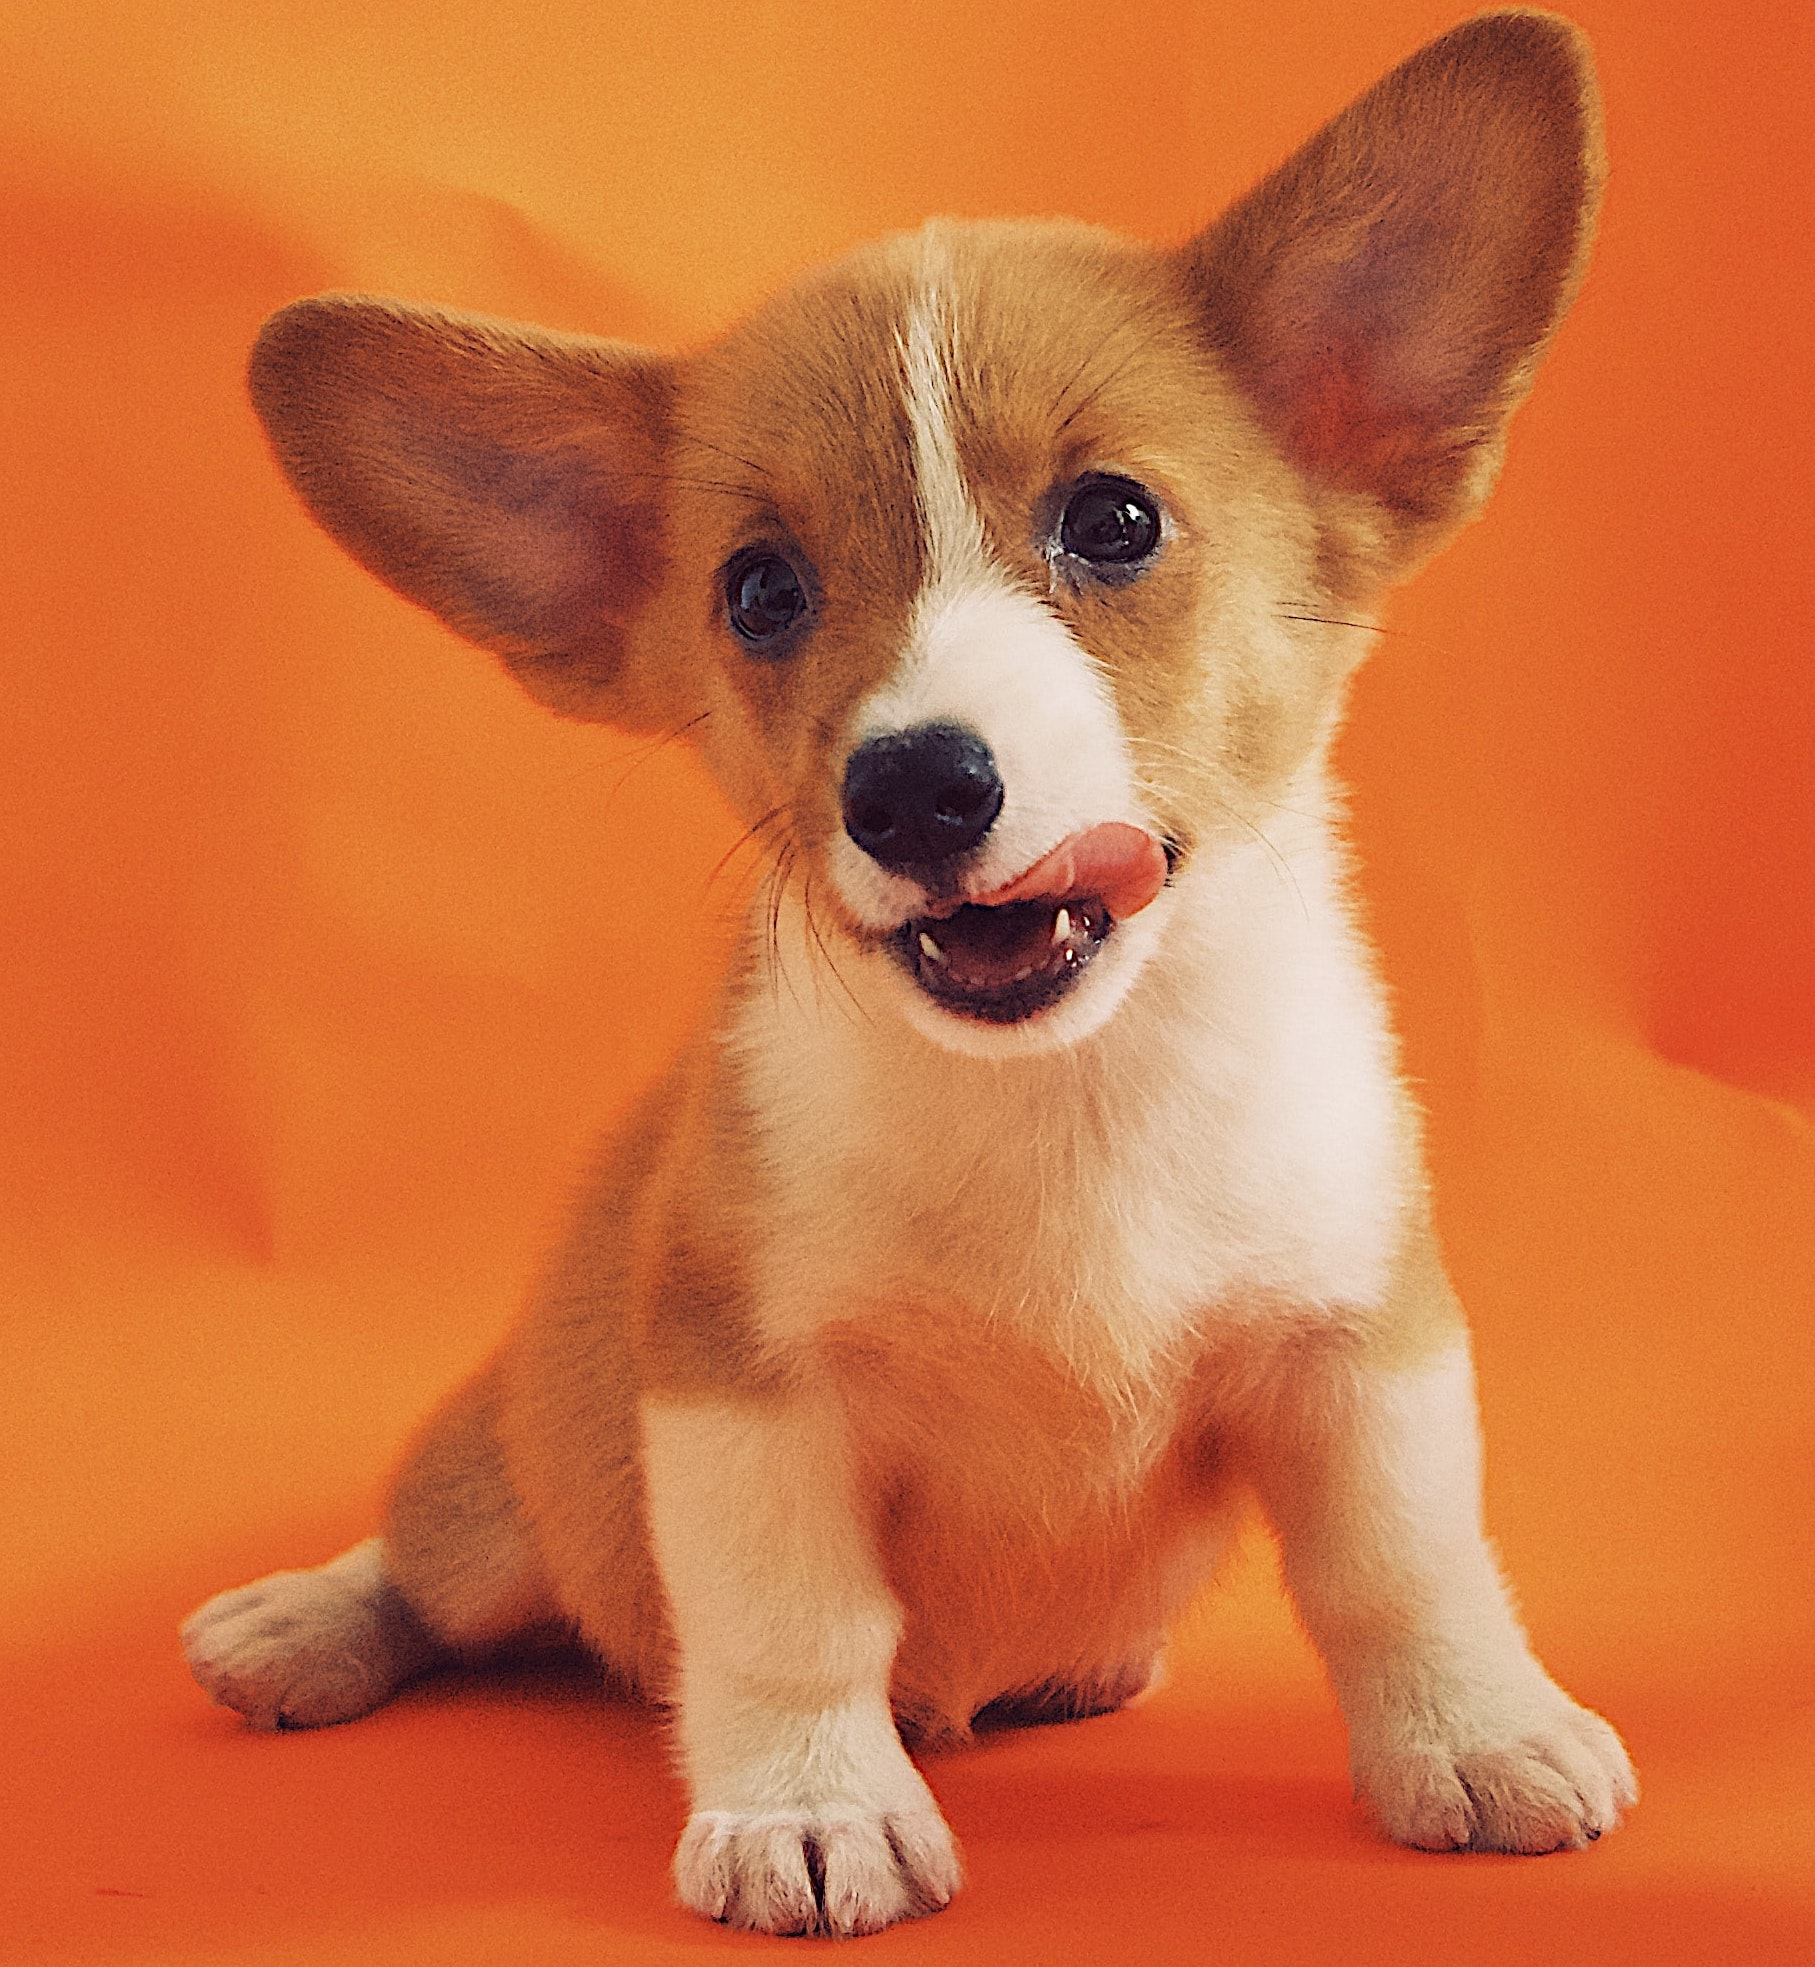

In [31]:
import os
from IPython.display import Image

files = os.listdir(dataset_dir)
image_file = [file for file in files if file.endswith((".jpg", ".jpeg", ".png"))][0]
sample_image = os.path.join(dataset_dir, image_file)
Image(filename=sample_image, width=400, height=400)

#### 4.2 Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

In [32]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

instance_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="Dog images for text to image dreambooth training",
    name="dog-images-text-to-image",
)

instance_data_uri_folder = workspace_ml_client.data.create_or_update(instance_data)

print(instance_data_uri_folder)
print("")
print("Path to folder in Blob Storage:")
print(instance_data_uri_folder.path)

creation_context:
  created_at: '2024-04-29T09:29:54.683508+00:00'
  created_by: Gaurav Rajguru
  created_by_type: User
  last_modified_at: '2024-04-29T09:29:54.697994+00:00'
description: Dog images for text to image dreambooth training
id: /subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/grajguru-rg/providers/Microsoft.MachineLearningServices/workspaces/grajguru-ws/data/dog-images-text-to-image/versions/3
name: dog-images-text-to-image
path: azureml://subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/grajguru-rg/workspaces/grajguru-ws/datastores/workspaceblobstore/paths/LocalUpload/0efb0550a5b2a0ef53036f41be157388/dog-example/
properties: {}
tags: {}
type: uri_folder
version: '3'


Path to folder in Blob Storage:
azureml://subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/grajguru-rg/workspaces/grajguru-ws/datastores/workspaceblobstore/paths/LocalUpload/0efb0550a5b2a0ef53036f41be157388/dog-example/


### 5. Submit the fine tuning job using `transformers_text_to_image_dreambooth_finetuning_pipeline` component
 
Create the job that uses the `transformers_text_to_image_dreambooth_finetuning_pipeline` component for stable-diffusion-text-to-image task. Learn more in 5.2 about all the parameters supported for fine tuning.

#### 5.1 Get pipeline component

In [33]:
FINETUNE_PIPELINE_COMPONENT_NAME = "transformers_text_to_image_dreambooth_finetuning_pipeline"
# Gaurav
# pipeline_component_transformers_func = registry_ml_client.components.get(
#     name=FINETUNE_PIPELINE_COMPONENT_NAME, label="latest"
# )

pipeline_component_transformers_func = workspace_ml_client.components.get(
    name=FINETUNE_PIPELINE_COMPONENT_NAME, label="latest"
)

#### 5.2 Create arguments to be passed to `transformers_text_to_image_dreambooth_finetuning_pipeline` component

The `transformers_text_to_image_dreambooth_finetuning_pipeline` component consists of model selection and finetuning components.

*Uncomment one or more parameters below to provide specific values, if you wish you override the autoselected default values. Please visit this pipeline component in Azure ML studio to know more about arguments and their allowed values.*

In [34]:
pipeline_component_args = {
    # # Model import args
    "model_family": "HuggingFaceImage",
    "download_from_source": False,  # True for downloading a model directly from HuggingFace
    "mlflow_model": foundation_model.id,  # foundation_model.id is provided, only foundation_model gives UserErrorException: only path input is supported now but get: ...
    # "model_name": huggingface_model_name, # specify the model_name instead of mlflow_model if you want to use a model from the huggingface hub
    # # Finetune_args
    "task_name": "stable-diffusion-text-to-image",
    # # Instance prompt
    "instance_prompt": "A photo of a sks dog",
    "resolution": 512,
    # # Prior preservation loss
    "with_prior_preservation": True,
    "class_prompt": "a photo of dog",
    "num_class_images": 100,  # Number of images to generate with the class prompt for prior preservation.
    "class_data_dir": None,  # Optional parameter, You can place existing images in class_data_dir, and the training job will generate any additional images so that num_class_images are present in class_data_dir during training time.
    "prior_generation_precision": "fp32",
    "prior_loss_weight": 1.0,
    "sample_batch_size": 2,  # Number of samples to generate class images in each batch.
    # # Lora parameters
    # # LoRA reduces the number of trainable parameters by learning pairs of rank-decompostion matrices while freezing the original weights. This vastly reduces the storage requirement for large models adapted to specific tasks and enables efficient task-switching during deployment all without introducing inference latency. LoRA also outperforms several other adaptation methods including adapter, prefix-tuning, and fine-tuning.
    "apply_lora": True,
    # "lora_alpha": 128,
    "lora_r": 16,
    # "lora_dropout": 0.0,
    # "tokenizer_max_length": 77,
    # # Text Encoder
    "pre_compute_text_embeddings": True,
    "train_text_encoder": False,
    # "text_encoder_type": "CLIPTextModel",
    # "text_encoder_name": "openai/clip-vit-base-patch32", # Huggingface id of text encoder.
    # "text_encoder_use_attention_mask": False,
    # # UNET related
    "class_labels_conditioning": "timesteps",
    # # Noise Scheduler
    "noise_scheduler_name": "DDPMScheduler",  # Optional, default is used from the base model. If following scheduler related parameters are not provided, it is taken from model's scheduler config.
    # "noise_scheduler_num_train_timesteps": 1000,
    # "noise_scheduler_variance_type": "fixed_small",
    # "noise_scheduler_prediction_type": "epsilon",
    # "noise_scheduler_timestep_spacing": "leading",
    # "extra_noise_scheduler_args": "clip_sample_range=1.0; clip_sample=True" # Optional additional arguments that are supplied to noise scheduler. The arguments should be semi-colon separated key value pairs and should be enclosed in double quotes.
    # "offset_noise": False
    # # Training related
    "num_validation_images": 2, # Number of images to generate using instance_prompt. Images are stored in the output/checkpoint-* directories. Please note that this will increase the training time.
    "number_of_workers": 2,
    "number_of_epochs": 15,
    "max_steps": -1,
    "training_batch_size": 2,
    "auto_find_batch_size": False,
    "learning_rate": 1e-4,
    # "learning_rate_scheduler": "warmup_linear",
    # "warmup_steps": 0,
    # "optimizer": "adamw_hf",
    # "weight_decay": 0.0,
    # "gradient_accumulation_step": 1,
    # "max_grad_norm": 1.0,
    "precision": "16",
    "random_seed": 42,
    "logging_strategy": "epoch",
    # "logging_steps": 500, # Number of update steps between two logs if logging_strategy='steps'.
    "save_total_limit": -1,
    "save_as_mlflow_model": True,
}

In [35]:
# Ensure that the user provides only one of mlflow_model or model_name
if pipeline_component_args.get("mlflow_model") is None and pipeline_component_args.get("model_name") is None:
    raise ValueError("You must specify either mlflow_model or model_name for the model to finetune")
if pipeline_component_args.get("mlflow_model") is not None and pipeline_component_args.get("model_name") is not None:
    raise ValueError("You must specify ONLY one of mlflow_model and model_name for the model to finetune")
elif pipeline_component_args.get("mlflow_model") is None and pipeline_component_args.get("model_name") is not None:
    use_model_name = huggingface_model_name
elif pipeline_component_args.get("mlflow_model") is not None and pipeline_component_args.get("model_name") is None:
    use_model_name = aml_registry_model_name
print(f"Finetuning model {use_model_name}")

Finetuning model stabilityai-stable-diffusion-2-1


#### 5.3 Utility function to create pipeline using `transformers_text_to_image_dreambooth_finetuning_pipeline` component

In [36]:
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import PipelineComponent
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes


@pipeline()
def create_pipeline_transformers():
    """Create pipeline."""

    transformers_pipeline_component: PipelineComponent = pipeline_component_transformers_func(
        compute_model_import=cluster_name,
        compute_finetune=cluster_name,
        instance_data_dir=Input(type=AssetTypes.URI_FOLDER, path=instance_data_uri_folder.path),
        **pipeline_component_args,
    )
    return {
        # Map the output of the fine tuning job to the output of pipeline job so that we can easily register the fine tuned model. Registering the model is required to deploy the model to an online or batch endpoint.
        "trained_model": transformers_pipeline_component.outputs.mlflow_model_folder,
    }

#### 5.4 Run the fine tuning job

In [37]:
transformers_pipeline_object = create_pipeline_transformers()

# don't use cached results from previous jobs
transformers_pipeline_object.settings.force_rerun = True

# set continue on step failure to False
transformers_pipeline_object.settings.continue_on_step_failure = False

transformers_pipeline_object.display_name = use_model_name + "_finetuning_run_" + "text-to-image"
# Don't use cached results from previous jobs
transformers_pipeline_object.settings.force_rerun = True

print("Submitting pipeline")

transformers_pipeline_run = workspace_ml_client.jobs.create_or_update(
    transformers_pipeline_object, experiment_name=experiment_name
)

print(f"Pipeline created. URL: {transformers_pipeline_run.studio_url}")

Submitting pipeline
Pipeline created. URL: https://ml.azure.com/runs/modest_loquat_g618p6mb6r?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/grajguru-rg/workspaces/grajguru-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


In [38]:
workspace_ml_client.jobs.stream(transformers_pipeline_run.name)

RunId: modest_loquat_g618p6mb6r
Web View: https://ml.azure.com/runs/modest_loquat_g618p6mb6r?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/grajguru-rg/workspaces/grajguru-ws

Streaming logs/azureml/executionlogs.txt

[2024-04-29 09:30:39Z] Submitting 1 runs, first five are: a5ae0aeb:d9f80e63-4011-420a-ab09-e9f9e588eb79


### 6. Register the fine tuned model with the workspace

We will register the model from the output of the fine tuning job. This will track lineage between the fine tuned model and the fine tuning job. The fine tuning job, further, tracks lineage to the foundation model, data and training code.

In [ ]:
import time

# Generating a unique timestamp that can be used for names and versions that need to be unique
timestamp = str(int(time.time()))

In [ ]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

# Check if the `trained_model` output is available
print(f"Pipeline job outputs: {workspace_ml_client.jobs.get(transformers_pipeline_run.name).outputs}")

model_path_from_job = f"azureml://jobs/{transformers_pipeline_run.name}/outputs/trained_model"
print(f"Path to register model: {model_path_from_job}")

finetuned_model_name = f"{use_model_name.replace('/', '-')}-dog-text-to-image"
finetuned_model_description = f"{use_model_name.replace('/', '-')} fine tuned model for dog objects text to image"
prepare_to_register_model = Model(
    path=model_path_from_job,
    type=AssetTypes.MLFLOW_MODEL,
    name=finetuned_model_name,
    version=timestamp,  # use timestamp as version to avoid version conflict
    description=finetuned_model_description,
)
print(f"Prepare to register model: \n{prepare_to_register_model}")

# Register the model from pipeline job output
registered_model = workspace_ml_client.models.create_or_update(prepare_to_register_model)
print(f"Registered model: {registered_model}")

### 7. Deploy the fine tuned model to an online endpoint
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

In [ ]:
import datetime
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment

# Endpoint names need to be unique in a region, hence using timestamp to create unique endpoint name
online_endpoint_name = "text-to-image-dog-" + datetime.datetime.now().strftime("%m%d%H%M")
online_endpoint_description = (
    f"Online endpoint for {registered_model.name}, finetuned for dog text to image generation task."
)
# Create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description=online_endpoint_description,
    auth_mode="key",
    tags={"foo": "bar"},
)
workspace_ml_client.begin_create_or_update(endpoint).result()

In [ ]:
from azure.ai.ml.entities import OnlineRequestSettings, ProbeSettings

deployment_name = "text2img-dog-mlflow-deploy"
print(registered_model.id)
print(online_endpoint_name)
print(deployment_name)

# Create a deployment
demo_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_NC6s_v3",
    instance_count=1,
    request_settings=OnlineRequestSettings(
        max_concurrent_requests_per_instance=1,
        request_timeout_ms=90000,
        max_queue_wait_ms=500,
    ),
    liveness_probe=ProbeSettings(
        failure_threshold=49,
        success_threshold=1,
        timeout=299,
        period=180,
        initial_delay=180,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)
workspace_ml_client.online_deployments.begin_create_or_update(demo_deployment).wait()
endpoint.traffic = {deployment_name: 100}
workspace_ml_client.begin_create_or_update(endpoint).result()

### 8. Test the endpoint with sample data


In [ ]:
# Create request json
import base64
import json


request_json = {
    "input_data": [base64.b64encode(read_image(sample_image)).decode("utf-8")],
}

request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [ ]:
resp = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)

#### Visualize detections
Now that we have scored a test image, we can visualize the prediction for this image.

### 9. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

workspace_ml_client.online_endpoints.begin_delete(name=online_endpoint_name).wait()